# Bayesian Regression

In [1]:
%matplotlib inline
import csv
import numpy as np
# import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import scipy
import scipy.stats

In [2]:
np.set_printoptions(suppress=True)

### Prepare the features for use in statistical analysis.

In [3]:
pickledf = pd.read_pickle('cleandf')

In [4]:
dftouse=pickledf.copy()

In [5]:
dftouse['Log_ResidentialUnits'] = np.log(dftouse['RESIDENTIAL UNITS'].values+1)
dftouse['Log_CommercialUnits'] = np.log(dftouse['COMMERCIAL UNITS'].values+1)
dftouse['Log_TotalUnits'] = np.log(dftouse['TOTAL UNITS'].values+1)
dftouse['Log_GrossSqft'] = np.log(dftouse['GROSS SQUARE FEET'].values)
dftouse['Log_1count'] = np.log(dftouse['1-count'].values)
dftouse['Log_2count'] = np.log(dftouse['2-count'].values)
dftouse['Log_3count'] = np.log(dftouse['3-count'].values)
dftouse['Log_Hospitals'] = np.log(dftouse['Hospitals'].values+1)

In [6]:
dftouse.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,YEAR,price_ft,Log_Price_Sqft,1-mean_log_Pft,1-std_log_Pft,1-count,1-median_log_Pft,2-mean_log_Pft,2-std_log_Pft,2-count,2-median_log_Pft,3-mean_log_Pft,3-std_log_Pft,3-count,3-median_log_Pft,Hospitals,Bad Hospitals,High School Graduation Rate,College Graduation Rate,Hispanic,Black,Asian,White,Population,Labor Force,Employed,Unemployed,MONTH,MONTH/YEAR,10001,10002,10003,...,11366,11367,11368,11369,11370,11372,11373,11374,11375,11377,11378,11379,11385,11411,11412,11413,11414,11415,11416,11417,11418,11419,11420,11421,11422,11423,11426,11427,11428,11429,11432,11433,11434,11435,11436,11691,11692,11693,Q2,Q3,Q4,Log_Sale_Price,Log_ResidentialUnits,Log_CommercialUnits,Log_TotalUnits,Log_GrossSqft,Log_1count,Log_2count,Log_3count,Log_Hospitals
0,1,KIPS BAY,08 RENTALS - ELEVATOR APARTMENTS,2,966,1,D7,401-429 EAST 34TH STREET,10016,706,1,707,835279,1985,2,D7,443403000,2011-07-19,2011,530.844185,6.274469,5.484593,2.229844,27,6.114937,6.345817,0.365633,13,6.343441,5.556865,1.855114,22,6.326369,84,0,96.6,79.8,0.047922,0.035216,0.137032,0.759497,53754,77.4,73.5,5.0,7,"(7, 2011)",0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,19.909990,6.561031,0.693147,6.562444,13.635521,3.295837,2.564949,3.091042,4.442651
1,1,UPPER EAST SIDE (79-96),08 RENTALS - ELEVATOR APARTMENTS,2,1549,1,D6,305-315 EAST 86 STREET,10028,695,3,698,690703,1964,2,D6,395000000,2014-09-22,2014,571.881112,6.348931,6.945146,0.530601,22,6.999318,6.455037,1.230122,55,6.627145,6.285564,1.763125,23,6.708895,24,0,98.4,80.7,0.005956,0.011783,0.070935,0.884035,46169,74.5,70.3,5.6,9,"(9, 2014)",0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,19.794396,6.545350,1.386294,6.549651,13.445465,3.091042,4.007333,3.135494,3.218876
2,1,MIDTOWN CBD,22 STORE BUILDINGS,4,1290,72,K9,697 5 AVENUE,10022,0,3,3,10944,1925,4,K9,380600000,2012-10-11,2012,34777.046784,10.456713,6.204245,2.117714,21,6.595381,6.777954,0.932843,29,6.824027,6.252587,1.541622,13,6.714776,11,0,98.6,79.5,0.008050,0.023434,0.100010,0.852816,29317,71.4,66.9,6.3,10,"(10, 2012)",0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,19.757260,0.000000,1.386294,1.386294,9.300547,3.044522,3.367296,2.564949,2.484907
3,1,MIDTOWN CBD,22 STORE BUILDINGS,4,1290,72,K4,697 5 AVENUE,10022,0,1,1,10944,1925,4,K4,373486928,2014-10-28,2014,34127.095029,10.437847,6.935865,0.978736,41,7.038995,6.232447,1.982575,38,6.533203,6.204245,2.117714,21,6.595381,11,0,97.6,80.9,0.011381,0.016499,0.097613,0.860500,29699,71.6,67.0,6.5,10,"(10, 2014)",0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,19.738394,0.000000,0.693147,0.693147,9.300547,3.713572,3.637586,3.044522,2.484907
4,1,MURRAY HILL,08 RENTALS - ELEVATOR APARTMENTS,2,858,8,D8,7 EAST 28TH STREET,10016,397,1,398,388946,1998,2,D8,300000000,2012-12-04,2012,771.315298,6.648097,5.359823,2.291699,31,6.339263,5.484593,2.229844,27,6.114937,6.345817,0.365633,13,6.343441,84,0,96.9,80.3,0.037112,0.035193,0.137675,0.769212,52624,76.9,72.8,5.3,12,"(12, 2012)",0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,19.519293,5.986452,0.693147,5.988961,12.871196,3.433987,3.295837,2.564949,4.442651


#### Split into training and test sets

In [7]:
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(dftouse.shape[0]), train_size=0.7)
mask=np.ones(dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [8]:
continuous_test_features = ['Log_TotalUnits','YEAR BUILT','Log_Price_Sqft',
                 '1-mean_log_Pft', '1-std_log_Pft', 'Log_1count','1-median_log_Pft',
                 '2-mean_log_Pft', '2-std_log_Pft', 'Log_2count','2-median_log_Pft',
                 '3-mean_log_Pft', '3-std_log_Pft', 'Log_3count','3-median_log_Pft',
                 'Log_Hospitals', 'High School Graduation Rate', 'College Graduation Rate',
                 'Hispanic', 'Black', 'Asian', 'White','Labor Force', 'Employed', 'Unemployed', 'Population','ZIP CODE']

In [9]:
continuous_test_features

['Log_TotalUnits',
 'YEAR BUILT',
 'Log_Price_Sqft',
 '1-mean_log_Pft',
 '1-std_log_Pft',
 'Log_1count',
 '1-median_log_Pft',
 '2-mean_log_Pft',
 '2-std_log_Pft',
 'Log_2count',
 '2-median_log_Pft',
 '3-mean_log_Pft',
 '3-std_log_Pft',
 'Log_3count',
 '3-median_log_Pft',
 'Log_Hospitals',
 'High School Graduation Rate',
 'College Graduation Rate',
 'Hispanic',
 'Black',
 'Asian',
 'White',
 'Labor Force',
 'Employed',
 'Unemployed',
 'Population',
 'ZIP CODE']

In [10]:
test_df = dftouse[continuous_test_features]

## Bayesian Linear Regression

With our next regression, we want to incorporate an element of uncertainty into our model to hopefully create better predictions as a result of modeling the underlying distribution. By using Bayesian probability theorems and features, we can utilize some of the information that we scraped that didn't make it into the dataset, such as the underlying means and standard deviations for some of our datasets. This will allow us to not only create more complex, sophisticated models, but also give us an estimate of the actual distribution should we want to generate our own datapoints from our model.

In [110]:
y_train = np.array(test_df['Log_Price_Sqft'][mask])
y_test = np.array(test_df['Log_Price_Sqft'][~mask])

print len(y_train),len(y_test)
print y_test

64155 27496
[ 6.64809724  6.96221901  6.43652156 ..., -0.5535019  -0.25515888
 -0.91629073]


In [12]:
test_df.head()

,Log_TotalUnits,YEAR BUILT,Log_Price_Sqft,1-mean_log_Pft,1-std_log_Pft,Log_1count,1-median_log_Pft,2-mean_log_Pft,2-std_log_Pft,Log_2count,2-median_log_Pft,3-mean_log_Pft,3-std_log_Pft,Log_3count,3-median_log_Pft,Log_Hospitals,High School Graduation Rate,College Graduation Rate,Hispanic,Black,Asian,White,Labor Force,Employed,Unemployed,Population,ZIP CODE
0,6.562444,1985,6.274469,5.484593,2.229844,3.295837,6.114937,6.345817,0.365633,2.564949,6.343441,5.556865,1.855114,3.091042,6.326369,4.442651,96.6,79.8,0.047922,0.035216,0.137032,0.759497,77.4,73.5,5.0,53754,10016
1,6.549651,1964,6.348931,6.945146,0.530601,3.091042,6.999318,6.455037,1.230122,4.007333,6.627145,6.285564,1.763125,3.135494,6.708895,3.218876,98.4,80.7,0.005956,0.011783,0.070935,0.884035,74.5,70.3,5.6,46169,10028
2,1.386294,1925,10.456713,6.204245,2.117714,3.044522,6.595381,6.777954,0.932843,3.367296,6.824027,6.252587,1.541622,2.564949,6.714776,2.484907,98.6,79.5,0.008050,0.023434,0.100010,0.852816,71.4,66.9,6.3,29317,10022
3,0.693147,1925,10.437847,6.935865,0.978736,3.713572,7.038995,6.232447,1.982575,3.637586,6.533203,6.204245,2.117714,3.044522,6.595381,2.484907,97.6,80.9,0.011381,0.016499,0.097613,0.860500,71.6,67.0,6.5,29699,10022
4,5.988961,1998,6.648097,5.359823,2.291699,3.433987,6.339263,5.484593,2.229844,3.295837,6.114937,6.345817,0.365633,2.564949,6.343441,4.442651,96.9,80.3,0.037112,0.035193,0.137675,0.769212,76.9,72.8,5.3,52624,10016


In [14]:
X = test_df.drop(['Log_Price_Sqft','ZIP CODE'], axis=1)

## Principal Component Analysis

In order to perform a Bayesian regression on our data, we first opted to perform a Principal Component Analysis, which greatly reduces the dimensions of the data while retaining most of the variance between the predictors. 
This means that we lose the identity of the given labels of our predictors, and identifying the correlation between outputs and certain inputs at the end will be impossible. We benefit, however, by reducing the number of actual predictors for our y-value. In doing this, we avoid the 'curse of 'dimensionality', which occurs when the number of dimensions of the data is large. When this occurs, relationships between datapoints are lost in the greater distance between two points created by the added dimensions.

Another point: our model is built off the assumption that our inputs are Normally distributed, when in fact they are not. The problem lies with our demographic data (race, employment status, etc.), which is calculated on a zip code level. This means that it is bucketed into around 200 values for each demographic column, rather than being spread out like a true Normal distribution. By running a PCA, much of that data will be shrunken into a dimension that probably does not account for as much of the variance as another vector.

We first normalize all of the data, since Principal Component Analysis is very sensitive to the relative scale of the input vectors. In doing so, we hope that large values such as price/sqft. and population do not overshadow smaller numbers represented by percentages.

In [15]:
from sklearn.decomposition import PCA as sklearnPCA

sklearn_pca = sklearnPCA(n_components=3)
sklearn_transf = sklearn_pca.fit_transform(X)

In [20]:
# X_train = X[mask]
# X_test = X[~mask]

X_train = sklearn_transf[mask]
X_test = sklearn_transf[~mask]

In [21]:
# print X_test.count()

In [22]:
sklearn_transf

array([[  4043.97790564,    -42.60836122,    -57.25684223],
       [ 11628.97471225,    -20.78525471,    -55.44686161],
       [ 28480.96806508,     20.26666163,    -48.58809411],
       ..., 
       [ 17875.95841579,     16.23977627,      3.34022722],
       [  2254.95787732,     19.03476605,      0.71438309],
       [ -7457.04015338,      2.53766159,      2.71125892]])

In [23]:
feature1 = X_train[:,0]
feature2 = X_train[:,1]
feature3 = X_train[:,2]

In [24]:
mu1, sd1 = np.mean(feature1), np.std(feature1)
mu2, sd2 = np.mean(feature2), np.std(feature2)
mu3, sd3 = np.mean(feature3), np.std(feature3)

print sd1, sd2, sd3

25198.2492886 30.1833170117 15.1056815647


We see that almost all of the variance is represented in the first component, while very little of it is made up by the other two dimensions of the vector.

In [25]:
pca_test = sklearn_pca.fit_transform(dftouse[continuous_test_features][~mask])
testf1 = sklearn_transf[:,0]
testf2 = sklearn_transf[:,1]
testf3 = sklearn_transf[:,2]

We used the library pymc for most of our Bayesian Linear Regression, a very convenient, intuitive library that also had a lot of power. It allowed us to not only create common distributions, but create distributions represented as combinations and transformations of other random variables.

In [26]:
import pymc

Our bottom-line regression is the same between normal and Bayesian regression. Our objective is still to find the weights for our coefficient vector, represented as b and which will calculate: 
$$y = b_{0} + b_{1}x_{1} + b_{2}x_{2} + ...$$

The main caveat is that instead of calculating the Maximum Likelihood Estimate, we calculate for the Maximum A Posteriori, where:

$$P(D |\theta) \propto P(\theta | D) P(D) $$

$$and$$

$$\theta^{MAP} \propto \underset{\theta}{\operatorname{argmax}} P(\theta | D) P(D) $$

We start each beta value with a Uniform prior, an uninformative prior. A Uniform prior distribution for the regression coefficients says that all possible coefficients are equally likely, which means that in essence there is no prior distribution and it starts as an MLE. This has to be done, since the transformation into principal components means that we no longer have any information that we know about the vectors. 

In [27]:
train_std = np.std(y_train)
print train_std

0.803823227157


In [29]:
# http://austinrochford.com/posts/2013-09-02-prior-distributions-for-bayesian-regression-using-pymc.html
# pymc.Normal(name='beta1', mu=0, tau=1)
beta_min = -10**6
beta_max = 10**6

beta0_ols = pymc.Uniform(name='beta0', lower=beta_min, upper=beta_max)
beta1_ols = pymc.Uniform(name='beta1', lower=beta_min, upper=beta_max)
beta2_ols = pymc.Uniform(name='beta2', lower=beta_min, upper=beta_max)
beta3_ols = pymc.Uniform(name='beta3', lower=beta_min, upper=beta_max)

@pymc.deterministic
def y_hat_ols(x1=feature1, x2=feature2, x3=feature3, \
              beta0 = beta0_ols, beta1=beta1_ols, beta2=beta2_ols, beta3=beta3_ols):
    return beta0 + beta1 * x1 + beta2 * x2 + beta3 * x3

In [30]:
test_transf = sklearn_pca.fit_transform(X_test)

The conjugate of the Normal distribution is the Normal itself, which means that with a Normally distributed likelihood function, using a Normal prior will ensure us that the posterior distribution is also Normal.

In [31]:
print len(y_train)
y_train = y_train.reshape(64155,1)

64155


In [32]:
Y_ols = pymc.Normal(name='Y_ols', mu=y_hat_ols, tau=np.sqrt(train_std), value=y_train, observed=True)

In [33]:
ols_model = pymc.Model([Y_ols, beta0_ols, beta1_ols, beta2_ols, beta3_ols])
ols_map = pymc.MAP(ols_model)
ols_map.fit()

In [34]:
def get_coefficients(map_):
    ret = [{str(variable): variable.value} for variable in map_.variables if str(variable).startswith('beta')]
    betas = [0] * len(ret)

    for param in ret:
        for k,v in param.items():
            print k, v
            spot = int(k[-1])
            betas[spot] = float(v)

    return betas

betas = get_coefficients(ols_map)
print betas

beta3 -0.0195834602285
beta2 0.00207297371755
beta1 3.25844007917e-06
beta0 5.43237610927
[5.432376109273955, 3.258440079172453e-06, 0.002072973717554737, -0.019583460228531767]


In [35]:
from scipy.stats.stats import pearsonr

def pearson_scorer(pred, actual):
    rho, pvals = pearsonr(pred, actual)
    return np.abs(rho), pvals

In [47]:
def check_betas(y_test, X_test, b):
    
    y_preds = []
    
    for row in X_test:
        tot = b[0]
        for y, b_ in zip(row, b[1:]):
            tot +=float(y)*b_
        y_preds.append(tot)
    
    diff = []
    for y, y_bar in zip(y_preds, y_test):
        diff.append(abs(y - y_bar))
    
    avg = sum(diff)/len(diff)
    r, pv = pearsonr(y_test, y_preds)
    
    return y_preds, avg, r

ols_preds, avg, r = check_betas(y_test, test_transf, betas)
print avg, r


0.500894899307 0.305665114358


In [184]:
from sklearn import linear_model
# print y_train
clf = linear_model.BayesianRidge()
clf.fit(X_train, y_train)
print y_train
# print type(y_train)
gaus = clf.predict(X_test)

[  6.27446854   6.34893112  10.45671287 ...,  -0.98082925   0.38566248
  -0.64067311]


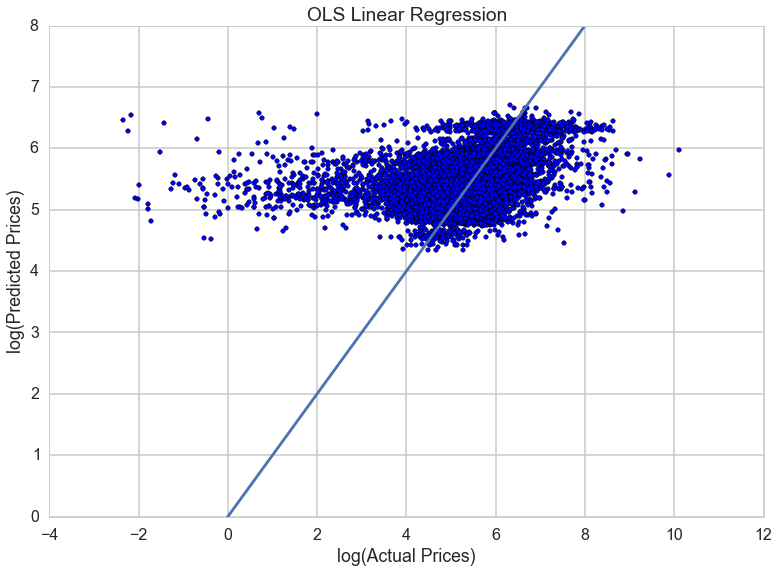

In [78]:
plt.scatter(y_test,ols_preds)
plt.xlabel("log(Actual Prices)")
plt.ylabel("log(Predicted Prices)")
plt.title("Bayesian Linear Regression")
plt.ylim(0,8)
# plt.xlim(6,20)
# plt.plot([0, 0], [1200000, 1200000])
xy = range(-2,11)
plt.plot(xy, xy)
plt.show()

Judging from the graph above, it is clear that our predicted y values do not adequately account for the wide range of values in the dataset. It tends to predict conservatively, predicting prices around the mean population. This is due to its nature as a Normal distribution, as the variance of N probably does not adequately account for the tail ends of the Normal. We conjecture that the use of Principal Component Analysis may have squashed some of the variance that was inherent in the dataset, as smaller variance of the components after normalizing is to be expected.

# Bayesian Conjugacy

This time we try another Bayesian regression, except this time we will actually utilize the underlying information in trying to find the parameters of the distribution. We examine Bayes' Theorem in relation to our dataset, which states that:

$$ P(Y|X) \propto P(X|Y)P(Y) $$

We make several assumptions about the dataset and attach distributions to all of the individual probabilities on the right in order to generative an acceptable, working posterior distribution for P(Y).

#### The Prior Distribution

The prior probability of house prices in New York City can be assumed to be drawn from a Normal distribution, and in our case we will now be using a marginally informative prior rather than an uninformative one. 

In our case, we have taken the log of the housing data in order to account for the many outliers, and then normalized the data in order to make it look like a Normal distribution. With the Law of Large Numbers, we can assume that with our datapoints reaching the hundreds of thousands we can safely assume that the distribution for Y is approaching a Normal distribution.

$$ P(Y) \sim N(\mu_{y},\sigma_{y})$$



In [129]:
log_price = test_df['Log_Price_Sqft']
lpmu, lpstd = np.mean(log_price), np.std(log_price)

#### Likelihood Estimator for X

Our marginal likelihood distribution is heavily linked and we cannot assume indipendence between X and Y to get a nice and tidy prior distribution. (We would hope that) there is a high level of correlation between the two and will shift both the sample mean and standard deviation given the prior information. Despite this, we know that all the predictors in our input variables remain Normal, as:

$$ P(X | Y) \sim N(\mu_{x|y}, \sigma_{x|y})$$

Given that we have calculated our input probabilities directly from the citywide data for all of our estimators, we will make a very heavy assumption that the values for mu and sigma remain unchanged given that we already know the true distribution, and we draw from P(X) directly. While this most definitely will skew some of our results, the underlying dataset is large enough that hopefully it will not be too detrimental to our results.

Because both the prior distribution and the likelihood are both Normal, our posterior will be one as well as a result of conjugacy. As a result, and knowing enough information about the likelihood, we can model P(Y|X) itself directly with a Normal distribution.

To make our dataset a little easier to work with, we perform Principal Component Analysis once more, in order to bring our dataset down to one dimension from five and make simple Normal conjugacy possible. In doing so, we maintain most of the variance from our previous distribution, although we lose almost all the information about the mean.

In [168]:
pca = sklearnPCA(n_components=1)
transf = pca.fit_transform(X_cols)

transf_train = transf[mask]
transf_test = transf[~mask]

print transf_train[:5]

[[-0.90904542]
 [-1.97471092]
 [-1.68299216]
 [-1.81992232]
 [-1.31509248]]


Assuming that we know about the prior distribution, we can use P(Y)'s mean and variance to help us compute our posterior distribution: 

$$ \mu_{0}, \sigma_{0}$$

Principal Component Analysis is very useful in that it allows transformation of a dataset without sacrificing much of the variance that comes along with it; in this case, this has allowed us to keep the variance more or less the same, which is vital for calculating the posterior distribution. 

$$ \sigma' $$

We can compute the hyperparameters necessary for our posterior Normal distribution, namely:
    
$$ \mu = (\frac{u_{0}}{\sigma_{0}^{2}} + \frac{\sum_{i=1}^{n} x_{i} }{ \sigma^{2}})  /  (\frac{1}{\sigma_{0}^{2}+\frac{n}{\sigma^{2}}}) ,$$

Using our prior and likelihood distribution parameters, as well as information taken from our training set.


In [141]:
import math
tr_sd = np.std(transf_train)

# sigma = math.pow((1/math.pow(lpstd,2) + len(y_train)/math.pow(sigma,2)),-1)

x_i = 0
for x in transf_train:
    x_i += x[0]

u = (lpmu/math.pow(lpstd,2) + x_i/math.pow(sigma, 2))/(1/math.pow(lpstd,2)+(n/math.pow(sigma,2)))



In [150]:
print u, sigma

8.45013209171 64156.5548005


In [176]:
times = len(y_test)
vals = np.random.normal(u, lpstd, times)


In [177]:
print vals

[ 7.67461792  9.45536882  7.98288558 ...,  8.305353    8.74290106
  8.09608559]


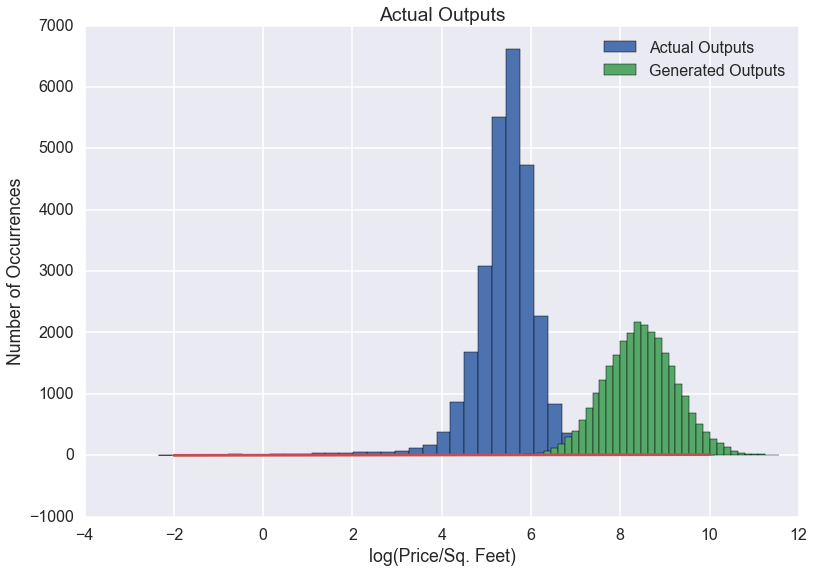

In [183]:
plt.hist(y_test, 40,label='Actual Outputs')
plt.hist(vals,40, label='Generated Outputs')
plt.legend()
plt.xlabel("log(Price/Sq. Feet)")
plt.ylabel("Number of Occurrences")
plt.title("Actual Outputs")
# plt.ylim(0,8)
# plt.xlim(6,20)
# plt.plot([0, 0], [1200000, 1200000])
xy = range(-2,11)
plt.plot(xy, xy)
plt.show()

Our generative model seems to overestimate the mean, and is much more spread out than the actual target data, which seems to be much more bunched around 5.8 or so. Despite the log scale, the outputs aren't necessarily orders of magnitude off, since the data was already logged when we began regressing on it.